# **Machine Learning for Air Quality Prediction in Africa**
### By Benjamin Yang
### Geophysical Inverse Theory
### Final Class Project

### Set up workspace

In [ ]:
# Import modules
import os
import numpy as np
import pandas as pd
import datetime as dts
from datetime import date, time, timedelta
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
!pip install basemap
from mpl_toolkits.basemap import Basemap
from matplotlib import dates
import re
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from google.colab import drive
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

     |████████████████████████████████| 863 kB 5.2 MB/s 
     |████████████████████████████████| 30.5 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 44.4 MB/s 
     |████████████████████████████████| 219 kB 46.1 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=293e693685a79adee9cf0cdad54030784d01dc4ef13594c14da32241a0f596f3
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [ ]:
# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory
base_dir = '/content/drive/My Drive/Colab Notebooks/Inverse_Theory/'
os.chdir(base_dir) 

### Define functions

In [ ]:
# Get all dates between start and end dates inclusive
def date_range(start, end, delta):
    curr = start
    while curr <= end:
        yield curr
        curr += delta

# Get meteorological season based on month
def get_season(month):
    if (month == 12 or 1 <= month <= 2):
        return 1  # winter   
    elif (3 <= month <= 5):
        return 2  # spring
    elif (6 <= month <= 8):
        return 3  # summer
    else:
        return 4  # fall

# Get values from 2D dataframe within bounding box and convert to 1D column
def slice_df(df,lats,lons):
  lat_idx = [np.argmin(np.abs(df.index - l)) for l in lats]
  lon_idx = [np.argmin(np.abs(df.columns.astype(float) - l)) for l in lons]
  return df.loc[df.index[lat_idx],df.columns[lon_idx]].values.ravel()

### Read in and process data 

In [ ]:
# Define AirNow sites and coordinates
sites = ['Abidjan','Abuja','Accra','Addis_Ababa','Bamako','Conakry','Kampala','Khartoum','Kigali','Kinshasa','Lagos','Libreville','Nairobi','NDjamena']
lat_obs = [5.3600,9.0765,5.6037,8.9806,12.6392,9.6412,0.3476,15.5007,-1.9441,-4.4419,6.5244,0.4162,-1.2921,12.1348]
lon_obs = [-4.0083,7.3986,-0.1870,38.7578,-8.0029,-13.5784,32.5825,32.5599,30.0619,15.2663,3.3792,9.4673,36.8219,15.0557]
print(min(lat_obs),max(lat_obs),min(lon_obs),max(lon_obs)) # bbox: -6,16,-15,40

-4.4419 15.5007 -13.5784 38.7578


In [ ]:
# Enter start and end dates
start = date(2018,1,1)
end = date(2019,12,31)

# Calculate and save all-inclusive dates in a list
alldates=[]
for result in date_range(start, end, relativedelta(months=1)):
    alldates.append(str(result))

In [ ]:
# Combine all features + PM2.5 into dataframes
df_site = [] # observation sites 
df_all = [] # all grid cells
for d in alldates:
    # Read in model output file
    d_sub = re.sub('-','',str(d))
    nc = Dataset('GEOSChem.AerosolMass.%s_0000z.nc4'%d_sub,'r')

    if d == alldates[0]:
        # Extract latitude/longitude 
        lat = nc.variables['lat'][:] # Latitude (degrees N)
        lon = nc.variables['lon'][:] # Longitude (degress E)
        lat_slice = np.where((lat>=-6) & (lat<=16))[0]
        lon_slice = np.where((lon>=-15) & (lon<=40))[0]
        lats = nc.variables['lat'][lat_slice]
        lons = nc.variables['lon'][lon_slice]

        # Read in topography data
        topo_df = pd.read_csv(base_dir+'SRTM_RAMP2_TOPO_2000-02-11_rgb_360x180.SS.CSV',index_col=0,header=0)
        topo = slice_df(topo_df,lats,lons)
        # Read in population data
        pop_df = pd.read_csv(base_dir+'Population.csv',index_col=0,header=0)
        pop = slice_df(pop_df,lats,lons)

    # Read in AOD data
    aod_df = pd.read_csv(base_dir+'MODAL2_M_AER_OD_%s_rgb_360x180.SS.CSV'%d,index_col=0,header=0)
    aod = slice_df(aod_df,lats,lons)
    # Read in WV data
    wv_df = pd.read_csv(base_dir+'MODAL2_M_SKY_WV_%s_rgb_360x180.SS.CSV'%d,index_col=0,header=0)
    wv = slice_df(wv_df,lats,lons)
    # Read in NDVI data
    ndvi_df = pd.read_csv(base_dir+'MOD_NDVI_M_%s_rgb_360x180.SS.CSV'%d,index_col=0,header=0)
    ndvi = slice_df(ndvi_df,lats,lons)
    # Read in SW data
    sw_df = pd.read_csv(base_dir+'CERES_SWFLUX_M_%s_rgb_360x180.SS.CSV'%d,index_col=0,header=0)
    sw = slice_df(sw_df,lats,lons)
    
    # Add date and season as features
    dt = pd.to_datetime(d).date()
    season = get_season(dt.month)
    
    # Extract PM2.5 data
    pm = nc.variables['PM25'][0,0,lat_slice,lon_slice] # particulate matter with radii < 2.5 um
    df_slice = pd.DataFrame(pm,index=lats,columns=lons).stack().reset_index()
    df_slice.columns = ['lat','lon','pm']
    df_slice = df_slice.assign(topo=topo,pop=pop,aod=aod,wv=wv,ndvi=ndvi,sw=sw,dt=dt,season=season)
    df_all.append(df_slice)

    # Get PM2.5 and features for each site 
    for i,s in enumerate(sites): 
        ix1 = np.argmin(np.abs(lat - lat_obs[i]))
        iy1 = np.argmin(np.abs(lon - lon_obs[i]))
        pm = nc.variables['PM25'][0,0,ix1,iy1]

        ix2 = np.argmin(np.abs(aod_df.index - lat_obs[i]))
        iy2 = np.argmin(np.abs(pd.to_numeric(aod_df.columns.values) - lon_obs[i]))
        aod = aod_df.loc[aod_df.index[ix2],aod_df.columns[iy2]]
        wv = wv_df.loc[wv_df.index[ix2],wv_df.columns[iy2]]
        ndvi = ndvi_df.loc[ndvi_df.index[ix2],ndvi_df.columns[iy2]]
        sw = sw_df.loc[sw_df.index[ix2],sw_df.columns[iy2]]
        topo = topo_df.loc[topo_df.index[ix2],topo_df.columns[iy2]]
        pop = pop_df.loc[pop_df.index[ix2],pop_df.columns[iy2]]

        df_s = pd.DataFrame({'site':[s],'lat':[lat_obs[i]],'lon':[lon_obs[i]],'dt':[dt],
                             'pm':[pm],'aod':[aod],'wv':[wv],'ndvi':[ndvi],'sw':[sw],
                             'topo':[topo],'pop':[pop],'season':[season]})
        df_site.append(df_s)
    
    # Close the netCDF file
    nc.close()
    print(d)

# Convert lists into single dataframes
df_site = pd.concat(df_site,ignore_index=True)
df_all = pd.concat(df_all,ignore_index=True)

2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01
2018-11-01
2018-12-01
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01
2019-11-01
2019-12-01


In [ ]:
# Perform time shift (previous month) - SITES
pm_shift = []
for s in sites:
    pm = df_site[df_site['site']==s]['pm']
    pm_df = pd.DataFrame(np.roll(pm,1).astype(float),index=pm.index) # perform time shift (previous month)
    pm_shift.append(pm_df)

pm_shift = pd.concat(pm_shift)
df_site['pm_shift'] = pm_shift

In [ ]:
# Perform time shift (previous month) - ALL
pm_all_shift = []
for i,df in df_all.groupby(['lat','lon']):
    pm_df = pd.DataFrame(np.roll(df['pm'],1).astype(float),index=df['pm'].index) # perform time shift (previous month)
    pm_all_shift.append(pm_df)

pm_all_shift = pd.concat(pm_all_shift)
df_all['pm_shift'] = pm_all_shift

In [ ]:
# Set invalid values to "Not a Number" - SITES
features = ['aod','wv','ndvi','sw','topo','pop','season','pm_shift']
for f in features:
    df_site.loc[df_site[f]==99999.000,f] = np.nan
df_site

,site,lat,lon,dt,pm,aod,wv,ndvi,sw,topo,pop,season,pm_shift
0,Abidjan,5.3600,-4.0083,2018-01-01,70.150444,1.000,3.07,0.672,83.66,83.43,86.50,1.0,50.197674
1,Abuja,9.0765,7.3986,2018-01-01,143.12645,0.409,1.94,0.372,78.64,699.96,48.42,1.0,84.098824
2,Accra,5.6037,-0.1870,2018-01-01,92.26453,1.000,2.95,NaN,78.64,22.32,NaN,1.0,54.869404
3,Addis_Ababa,8.9806,38.7578,2018-01-01,14.451465,0.197,0.90,0.333,85.33,2635.65,166.14,1.0,8.898671
4,Bamako,12.6392,-8.0029,2018-01-01,107.85185,0.283,2.13,0.290,81.99,458.70,24.31,1.0,67.094498
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Kinshasa,-4.4419,15.2663,2019-12-01,11.493128,NaN,NaN,0.735,147.24,419.12,46.70,1.0,5.369608
332,Lagos,6.5244,3.3792,2019-12-01,54.844738,0.524,3.00,NaN,73.62,2.48,1517.41,1.0,13.974483
333,Libreville,0.4162,9.4673,2019-12-01,12.100684,NaN,4.96,0.660,118.80,14.28,5.11,1.0,4.615307
334,Nairobi,-1.2921,36.8219,2019-12-01,9.117903,0.000,2.31,0.613,112.11,1200.32,14.11,1.0,4.400460


In [ ]:
# Set invalid values to "Not a Number" - ALL
for f in features:
    df_all.loc[df_all[f]==99999.000,f] = np.nan
df_all

,lat,lon,pm,topo,pop,aod,wv,ndvi,sw,dt,season,pm_shift
0,-6.0,-15.0,2.792257,NaN,NaN,0.201,2.50,NaN,56.89,2018-01-01,1.0,2.318520
1,-6.0,-12.5,2.969951,NaN,NaN,0.362,2.48,NaN,65.26,2018-01-01,1.0,2.509573
2,-6.0,-10.0,3.406005,NaN,NaN,0.366,2.34,NaN,65.26,2018-01-01,1.0,2.679744
3,-6.0,-7.5,3.821205,NaN,NaN,0.343,2.57,NaN,65.26,2018-01-01,1.0,2.920955
4,-6.0,-5.0,4.039658,NaN,NaN,0.244,2.57,NaN,61.91,2018-01-01,1.0,3.271014
...,...,...,...,...,...,...,...,...,...,...,...,...
6619,16.0,30.0,52.576443,289.27,18.86,0.114,0.78,0.101,105.41,2019-12-01,1.0,38.224716
6620,16.0,32.5,51.766415,289.27,18.86,0.098,0.97,0.113,88.68,2019-12-01,1.0,29.879734
6621,16.0,35.0,32.839741,289.27,18.86,0.098,1.51,0.073,68.60,2019-12-01,1.0,21.302389
6622,16.0,37.5,27.397829,289.27,18.86,0.094,1.54,0.148,68.60,2019-12-01,1.0,23.639311


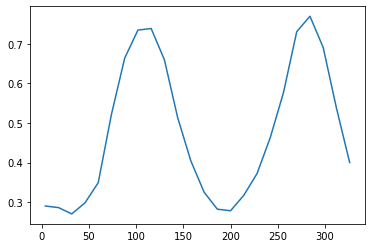

In [ ]:
# Sample time series
df_site[df_site['site']=='Bamako']['ndvi'].astype(float).plot()

### Train & test XGBoost model at AirNow sites

In [26]:
#features = ['aod','wv','ndvi','sw','topo','pop','season'] # features 1-7
features = ['aod','wv','ndvi','sw','topo','pop','season','pm_shift'] # all features (including shifted PM2.5)
# Define independent and dependent variables
x = df_all[features]
y = df_all['pm']

# Perform train/test splits
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

###############################
#####   TESTING XGBOOST   #####
###############################

# Instantiate model 
#xgb = XGBRegressor(random_state=1,verbosity=0) # default hyperparameters
xgb = XGBRegressor(random_state=1,verbosity=0,n_estimators=400,max_depth=8,learning_rate=0.04,colsample_bytree=1.0,subsample=0.5) # best hyperparameters

# Train the model on training data
#xgb.fit(x_train.values.reshape(-1,1), y_train)
xgb.fit(x_train, y_train)

# Use the forest's predict method on the test data
#y_pred_xgb = xgb.predict(x_test.values.reshape(-1,1))
y_pred_xgb = xgb.predict(x_test)
#print("Prediction for test set: {}".format(y_pred_xgb))

'''
#####################################
#####   HYPERPARAMETER TUNING   #####
#####################################

# Instantiate XGBoost model with constant random state for reproducibility
xgb = XGBRegressor(random_state=1)

# Show current parameters
print('XGB parameters currently in use:\n')
print(xgb.get_params())

# Create parameter grid 
param_grid = {
    'n_estimators': [200,300,400], #400
    'max_depth': [6,7,8], #8
    'learning_rate': [0.03,0.04,0.05], #0.04
    'colsample_bytree': [0.8,0.9,1.0], #1.0
    'subsample': [0.5,0.6,0.7] #0.5
}

# Instantiate grid search for "optimal" parameters using 5 fold cross validation  
# and use all available cores
grid_search = GridSearchCV(estimator=xgb,param_grid=param_grid,cv=5,n_jobs=-1,verbose=2)

# Fit grid search to the data and make predictions
grid_search.fit(x_train, y_train)
grid_search.best_params_
xgb = grid_search.best_estimator_
y_pred_xgb = xgb.predict(x_test)
'''
# Model evaluation statistics 
r2_xgb = metrics.r2_score(y_test, y_pred_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = metrics.mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb))
print('XGB stats...')
print('R squared:', r2_xgb)
print('Mean Absolute Error:', mae_xgb)
print('Mean Square Error:', mse_xgb)
print('Root Mean Square Error:', rmse_xgb)

# Predicted vs. observed PM2.5 
xgb_diff = pd.DataFrame({'Observed value': y_test, 'Predicted value': y_pred_xgb})
xgb_diff.head()

XGB stats...
R squared: 0.8490587044278979
Mean Absolute Error: 7.8244324
Mean Square Error: 223.80856
Root Mean Square Error: 14.960233


,Observed value,Predicted value
4015,43.596226,51.055943
5744,46.850224,26.638071
311,14.559893,22.108702
2990,43.525330,38.804848
116,33.414639,29.012299


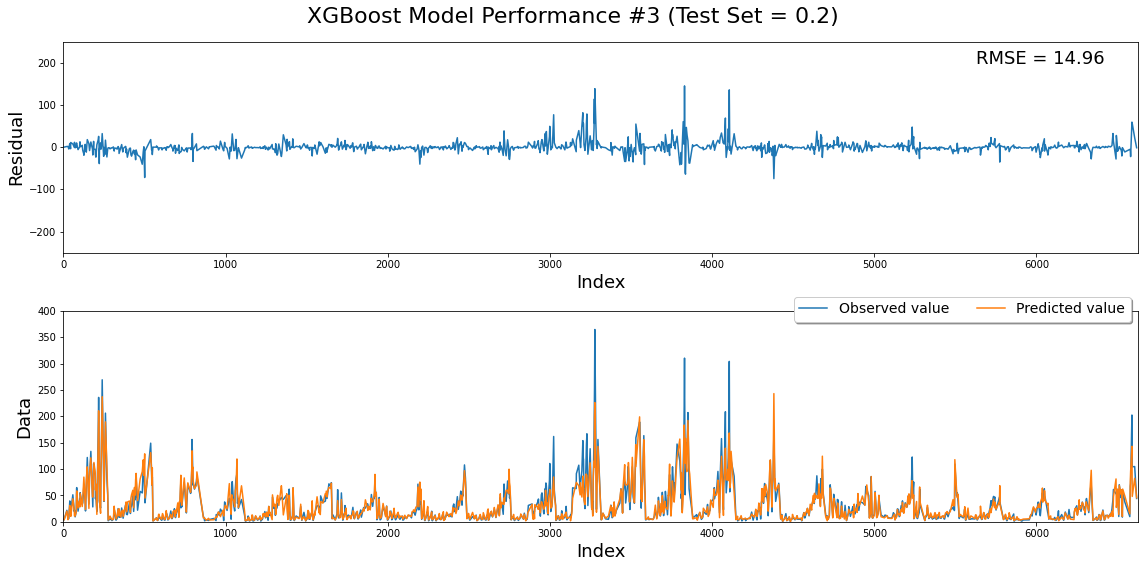

In [ ]:
# Compute residuals
e = y_test - y_pred_xgb

# Create two-panel plots of data and residuals
fig1=plt.figure(figsize=(16,8))
fig1.suptitle('XGBoost Model Performance #3 (Test Set = 0.2)',fontsize=22)
ax1=fig1.add_subplot(2,1,1)
e.sort_index().plot()
ax1.annotate('RMSE = %.2f'%rmse_xgb,xy=(0.85,0.96),xycoords='axes fraction',fontsize=18,horizontalalignment='left',verticalalignment='top')
ax1.set_xlabel('Index',fontsize=18)
ax1.set_ylabel('Residual',fontsize=18)
ax1.set_xlim([0,len(y)])
ax1.set_ylim([-250,250])

ax2=fig1.add_subplot(2,1,2)
xgb_diff.sort_index().plot(ax=ax2)
ax2.set_xlabel('Index',fontsize=18)
ax2.set_ylabel('Data',fontsize=18)
ax2.set_xlim([0,len(y)])
ax2.set_ylim([0,400])
ax2.legend(loc='upper right',fancybox=True,shadow=True,fontsize=14,ncol=2,bbox_to_anchor=(1,1.1))

fig1.tight_layout()
fig1.subplots_adjust(top=0.92)
fig1.savefig(base_dir+'Figures/residual_3.png',dpi=300,bbox_inches='tight')

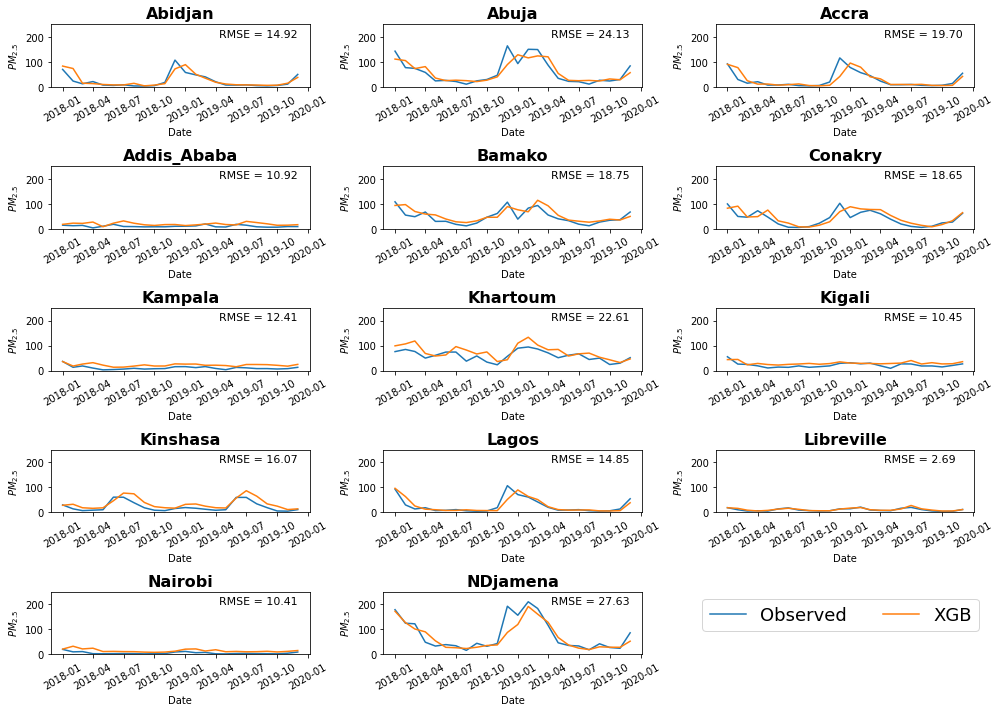

In [ ]:
# Create time series for each site (predicted vs. observed) 
fig2=plt.figure(figsize=(14,10))
for i,s in enumerate(sites):
    # Get data for specific test site
    df_site2 = df_site.set_index('dt')
    x_new = df_site2[df_site2['site']==s][features]
    y_new = df_site2[df_site2['site']==s]['pm']
    
    # Make predictions
    y_pred_xgb_new = xgb.predict(x_new)
    
    # Model evaluation statistics
    rmse_xgb_new = np.sqrt(metrics.mean_squared_error(y_new, y_pred_xgb_new))
    
    # Construct data frame with new predictions
    ml_diff = pd.DataFrame({'Observed': y_new.astype(float),'XGB': y_pred_xgb_new})
   
    # Predicted vs. observed PM2.5 for specific site
    ax13=fig2.add_subplot(5,3,i+1)
    ml_diff.plot(ax=ax13,legend=False)
    ax13.annotate('RMSE = %.2f'%rmse_xgb_new,xy=(0.65,0.93),xycoords='axes fraction',fontsize=11,horizontalalignment='left',verticalalignment='top')
    ax13.set_title(s,fontsize='16',fontweight='bold')
    ax13.set(xlabel='Date',ylabel='$PM_{2.5}$',ylim=(0,250))
    ax13.xaxis.set_tick_params(rotation=30)

handles, labels = ax13.get_legend_handles_labels()
fig2.legend(handles,labels,loc='lower right',bbox_to_anchor=(0.98,0.1),ncol=4,fontsize=18)
fig2.tight_layout()
fig2.savefig(base_dir+'Figures/time_series_all_sites.png',dpi=300,bbox_inches='tight')

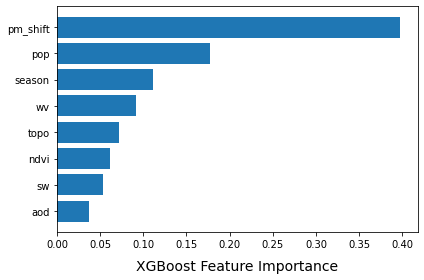

In [ ]:
# Plot feature importance
sorted_idx = xgb.feature_importances_.argsort()
fig3=plt.figure(figsize=(6,4))
plt.barh(np.array(features)[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance",fontsize=14,labelpad=10)
fig3.tight_layout()
fig3.savefig(base_dir+'Figures/feature_importance.png',dpi=300,bbox_inches='tight')

## Run model 100 times to obtain confidence interval

In [27]:
rmse_xgb_1 = [] # features 1-7
rmse_xgb_2 = [] # all features (including shifted PM2.5)
rmse_xgb_3 = [] # all features + best hyperparameters

for tc in [1,2,3]:
  if tc==1:
    features = ['aod','wv','ndvi','sw','topo','pop','season']
  else:
    features = ['aod','wv','ndvi','sw','topo','pop','season','pm_shift']

  # Define independent and dependent variables
  x = df_all[features]
  y = df_all['pm']
 
  print(tc)
  for i in np.arange(0,100):
    # Perform train/test splits
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

    # Instantiate model 
    if tc==3:
      xgb = XGBRegressor(verbosity=0,n_estimators=400,max_depth=8,learning_rate=0.04,colsample_bytree=1.0,subsample=0.5)
    else:
      xgb = XGBRegressor(verbosity=0)

    # Train the model on training data
    #xgb.fit(x_train.values.reshape(-1,1), y_train)
    xgb.fit(x_train, y_train)

    # Use the forest's predict method on the test data
    #y_pred_xgb = xgb.predict(x_test.values.reshape(-1,1))
    y_pred_xgb = xgb.predict(x_test)
    #print("Prediction for test set: {}".format(y_pred_xgb))

    rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb))
    if tc==1:
      rmse_xgb_1.append(rmse_xgb)
    if tc==2:
      rmse_xgb_2.append(rmse_xgb)
    if tc==3:
      rmse_xgb_3.append(rmse_xgb)

1
2
3


In [ ]:
# Compute mean, standard deviations, and 95 percent confidence intervals
rmse_mean = [np.mean(rmse_xgb_1),np.mean(rmse_xgb_2),np.mean(rmse_xgb_3)]
rmse_std = [np.std(rmse_xgb_1),np.std(rmse_xgb_2),np.std(rmse_xgb_3)]
rmse_2std = [2*np.std(rmse_xgb_1),2*np.std(rmse_xgb_2),2*np.std(rmse_xgb_3)]

n = len(rmse_xgb_1) # number of obs
z = 1.96 # for a 95% CI
ci = [z*(np.std(rmse_xgb_1)/np.sqrt(n)),z*(np.std(rmse_xgb_2)/np.sqrt(n)),z*(np.std(rmse_xgb_3)/np.sqrt(n))]

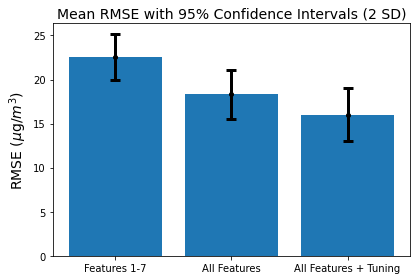

In [ ]:
# Plot mean RMSE with 95% confidence intervals
fig4=plt.figure(figsize=(6,4))
tc_label = ['Features 1-7','All Features','All Features + Tuning']
plt.errorbar(tc_label,rmse_mean, yerr=rmse_2std, fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.bar(tc_label,rmse_mean,tick_label=tc_label) 
plt.ylabel('RMSE ($\mu$g/$m^{3}$)',fontsize=14)
plt.title('Mean RMSE with 95% Confidence Intervals (2 SD)',fontsize=14)
fig4.tight_layout()
fig4.savefig(base_dir+'Figures/real_ci.png',dpi=300,bbox_inches='tight')

### Test over all grid points

In [28]:
# Include all features
features = ['aod','wv','ndvi','sw','topo','pop','season','pm_shift']

# Define train/test features and labels
x_train = df_site[features]
x_test = df_all[features]
y_train = df_site['pm']
y_test = df_all['pm']

###############################
#####   TESTING XGBOOST   #####
###############################

# Instantiate model
#xgb = XGBRegressor(random_state=1,verbosity=0) # default hyperparameters
xgb = XGBRegressor(random_state=1,verbosity=0,n_estimators=400,max_depth=8,learning_rate=0.04,colsample_bytree=1.0,subsample=0.5) # best hyperparameters

# Train the model on training data
#xgb.fit(x_train.values.reshape(-1,1), y_train)
xgb.fit(x_train, y_train)

# Use the forest's predict method on the test data
#y_pred_xgb = xgb.predict(x_test.values.reshape(-1,1))
y_pred_xgb = xgb.predict(x_test)
#print("Prediction for test set: {}".format(y_pred_xgb))

In [ ]:
# Compute residual
df_all['pm_pred'] = y_pred_xgb
df_all['pm_diff'] = y_test-y_pred_xgb
df_all

,lat,lon,pm,topo,pop,aod,wv,ndvi,sw,dt,season,pm_shift,pm_pred,pm_diff
0,-6.0,-15.0,2.792257,NaN,NaN,0.201,2.50,NaN,56.89,2018-01-01,1.0,2.318520,47.603500,-44.811245
1,-6.0,-12.5,2.969951,NaN,NaN,0.362,2.48,NaN,65.26,2018-01-01,1.0,2.509573,49.168541,-46.198589
2,-6.0,-10.0,3.406005,NaN,NaN,0.366,2.34,NaN,65.26,2018-01-01,1.0,2.679744,50.638466,-47.232460
3,-6.0,-7.5,3.821205,NaN,NaN,0.343,2.57,NaN,65.26,2018-01-01,1.0,2.920955,50.490005,-46.668800
4,-6.0,-5.0,4.039658,NaN,NaN,0.244,2.57,NaN,61.91,2018-01-01,1.0,3.271014,52.095543,-48.055885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619,16.0,30.0,52.576443,289.27,18.86,0.114,0.78,0.101,105.41,2019-12-01,1.0,38.224716,56.082104,-3.505661
6620,16.0,32.5,51.766415,289.27,18.86,0.098,0.97,0.113,88.68,2019-12-01,1.0,29.879734,48.318779,3.447636
6621,16.0,35.0,32.839741,289.27,18.86,0.098,1.51,0.073,68.60,2019-12-01,1.0,21.302389,75.544205,-42.704464
6622,16.0,37.5,27.397829,289.27,18.86,0.094,1.54,0.148,68.60,2019-12-01,1.0,23.639311,81.766586,-54.368759


In [ ]:
# Average over lat/lon grid cells
df_all_avg = df_all.groupby(['lat','lon']).mean()
lat_avg = df_all_avg.index.get_level_values(0)
lon_avg = df_all_avg.index.get_level_values(1)
pm_pred_avg = df_all_avg['pm_pred']
pm_avg = df_all_avg['pm']
pm_diff_avg = df_all_avg['pm_diff']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'tri'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'tri'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: The following kwargs were not used by contour: 'tri'


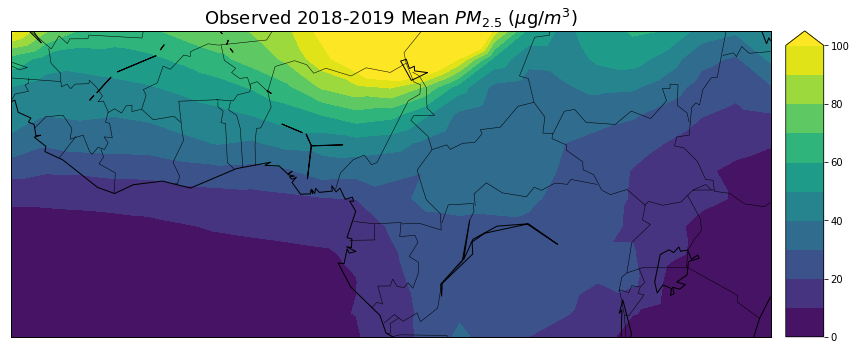

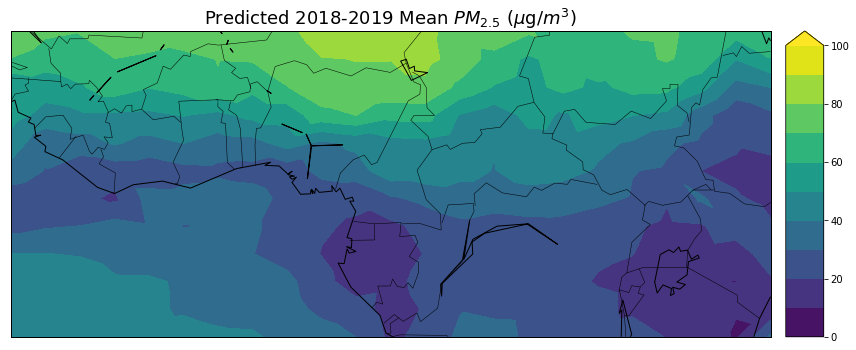

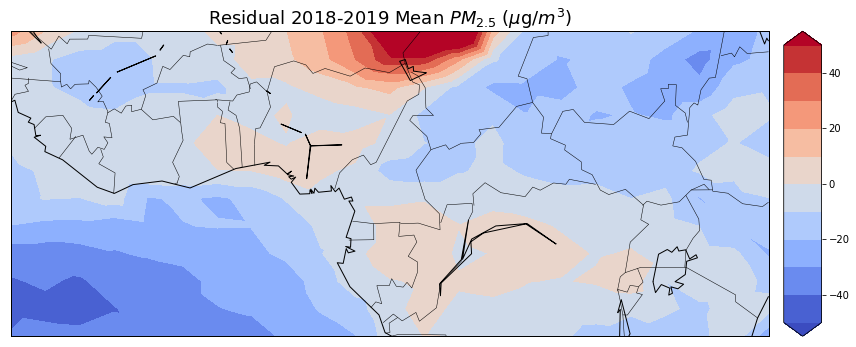

In [ ]:
# Compute annnual mean PM2.5
levels = np.linspace(0,100,10+1)
levels2 = np.linspace(-50,50,10+1)

# Create map of annual mean PM2.5
fig5 = plt.figure(figsize=(12,8))
m = Basemap(projection='mill',llcrnrlon=lon_avg.min(),llcrnrlat=lat_avg.min(),urcrnrlon=lon_avg.max(),urcrnrlat=lat_avg.max(),resolution='c')
#x,y = m(np.reshape(lon_avg,(12,23)),np.reshape(lat_avg,(12,23)))
#m.pcolormesh(x,y,pm_avg.unstack().values,vmi0)n=0,vmax=10
m.contourf(lon_avg,lat_avg,pm_avg,levels=levels,vmin=0,vmax=100,extend='max',tri=True,latlon=True)
m.colorbar(location='right')
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Observed 2018-2019 Mean $PM_{2.5}$ ($\mu$g/$m^{3}$)',fontsize=18);
fig5.tight_layout()
fig5.savefig(base_dir+'Figures/observed_pm_map_contour.png',dpi=300,bbox_inches='tight')

# Create map of annual mean PM2.5
fig6 = plt.figure(figsize=(12,8))
m = Basemap(projection='mill',llcrnrlon=lon_avg.min(),llcrnrlat=lat_avg.min(),urcrnrlon=lon_avg.max(),urcrnrlat=lat_avg.max(),resolution='c')
#m.pcolormesh(x,y,pm_pred_avg.unstack().values,vmin=0,vmax=100)
m.contourf(lon_avg,lat_avg,pm_pred_avg,levels=levels,vmin=0,vmax=100,extend='max',tri=True,latlon=True)
m.colorbar(location='right')
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Predicted 2018-2019 Mean $PM_{2.5}$ ($\mu$g/$m^{3}$)',fontsize=18);
fig6.tight_layout()
fig6.savefig(base_dir+'Figures/predicted_pm_map_contour.png',dpi=300,bbox_inches='tight')

# Create map of annual mean PM2.5
fig7 = plt.figure(figsize=(12,8))
m = Basemap(projection='mill',llcrnrlon=lon_avg.min(),llcrnrlat=lat_avg.min(),urcrnrlon=lon_avg.max(),urcrnrlat=lat_avg.max(),resolution='c')
#m.pcolormesh(x,y,pm_diff_avg.unstack().values,cmap='coolwarm',vmin=-40,vmax=40)
m.contourf(lon_avg,lat_avg,pm_diff_avg,levels=levels2,vmin=-50,vmax=50,extend='both',cmap='coolwarm',tri=True,latlon=True)
m.colorbar(location='right')
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Residual 2018-2019 Mean $PM_{2.5}$ ($\mu$g/$m^{3}$)',fontsize=18);
fig7.tight_layout()
fig7.savefig(base_dir+'Figures/residual_pm_map_contour.png',dpi=300,bbox_inches='tight')

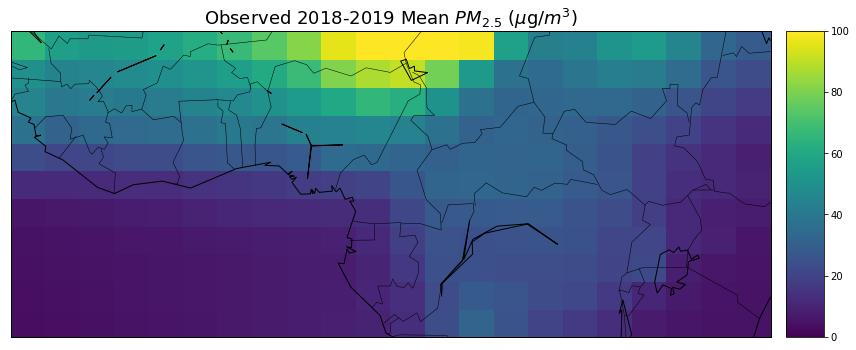

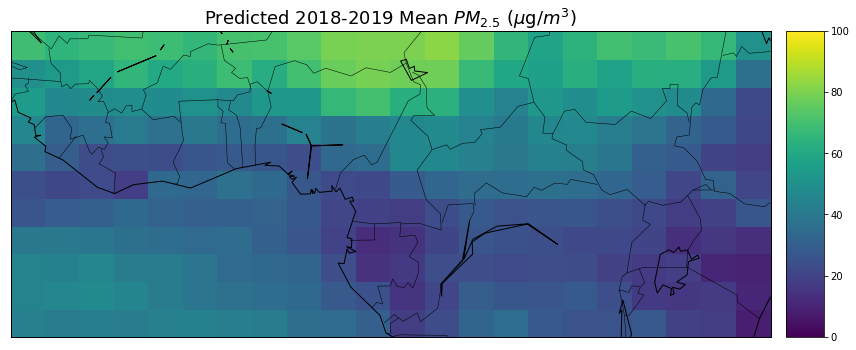

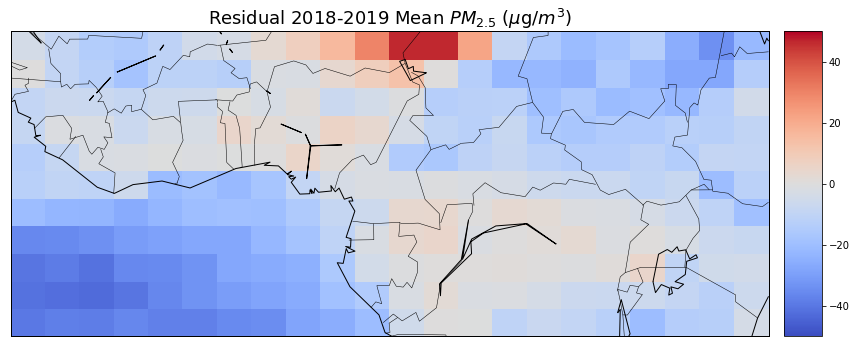

In [ ]:
# Compute annnual mean PM2.5
#pm_all_avg = np.mean(pm_all,axis=0)
levels = np.linspace(0,200,10+1)
levels2 = np.linspace(-100,100,10+1)

# Create map of annual mean PM2.5
fig8 = plt.figure(figsize=(12,8))
m = Basemap(projection='mill',llcrnrlon=lon_avg.min(),llcrnrlat=lat_avg.min(),urcrnrlon=lon_avg.max(),urcrnrlat=lat_avg.max(),resolution='c')
x,y = m(np.reshape(lon_avg,(12,23)),np.reshape(lat_avg,(12,23)))
m.pcolormesh(x,y,pm_avg.unstack().values,vmin=0,vmax=100)
#m.contourf(lon_avg,lat_avg,pm_avg,levels=levels,tri=True,latlon=True)
m.colorbar(location='right')
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Observed 2018-2019 Mean $PM_{2.5}$ ($\mu$g/$m^{3}$)',fontsize=18);
fig8.tight_layout()
fig8.savefig(base_dir+'Figures/observed_pm_map.png',dpi=300,bbox_inches='tight')

# Create map of annual mean PM2.5
fig9 = plt.figure(figsize=(12,8))
m = Basemap(projection='mill',llcrnrlon=lon_avg.min(),llcrnrlat=lat_avg.min(),urcrnrlon=lon_avg.max(),urcrnrlat=lat_avg.max(),resolution='c')
m.pcolormesh(x,y,pm_pred_avg.unstack().values,vmin=0,vmax=100)
#m.contourf(lon_avg,lat_avg,pm_pred_avg,levels=levels,tri=True,latlon=True)
m.colorbar(location='right')
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Predicted 2018-2019 Mean $PM_{2.5}$ ($\mu$g/$m^{3}$)',fontsize=18);
fig9.tight_layout()
fig9.savefig(base_dir+'Figures/predicted_pm_map.png',dpi=300,bbox_inches='tight')

# Create map of annual mean PM2.5
fig10 = plt.figure(figsize=(12,8))
m = Basemap(projection='mill',llcrnrlon=lon_avg.min(),llcrnrlat=lat_avg.min(),urcrnrlon=lon_avg.max(),urcrnrlat=lat_avg.max(),resolution='c')
m.pcolormesh(x,y,pm_diff_avg.unstack().values,cmap='coolwarm',vmin=-50,vmax=50)
#m.contourf(lon_avg,lat_avg,pm_diff_avg,levels=levels2,cmap='coolwarm',tri=True,latlon=True)
m.colorbar(location='right')
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Residual 2018-2019 Mean $PM_{2.5}$ ($\mu$g/$m^{3}$)',fontsize=18);
fig10.tight_layout()
fig10.savefig(base_dir+'Figures/residual_pm_map.png',dpi=300,bbox_inches='tight')